In [1]:
!pip install shapely==2.0.0 scipy==1.9.3

In [152]:
from scipy.spatial import Voronoi
from voronoiville import voronoi, BoundingBox
import shapely.geometry as geo
import numpy as np
from shapely.ops import polygonize
from IPython.display import SVG

In [153]:
points = np.random.random(size=(50, 2)) * 100
points_list = list(map(tuple, points.tolist()))

In [154]:
%%time
bounding_box_shape = geo.box(0, 0, 100, 100)

# This is a hack, otherwise it returns -1 for vertices with an "infinite" endpoint
cardinal_bounds =  [(-10000, -10000), ( 10000, -10000), (10000, 10000), (-10000, 10000)]
v = Voronoi(points_list + cardinal_bounds)
lines = polygonize([
    geo.LineString(v.vertices[line])
    for line in v.ridge_vertices if -1 not in line
])

result = geo.GeometryCollection([p.intersection(bounding_box_shape) for p in lines])


CPU times: user 4.87 ms, sys: 3.13 ms, total: 8 ms
Wall time: 12.5 ms


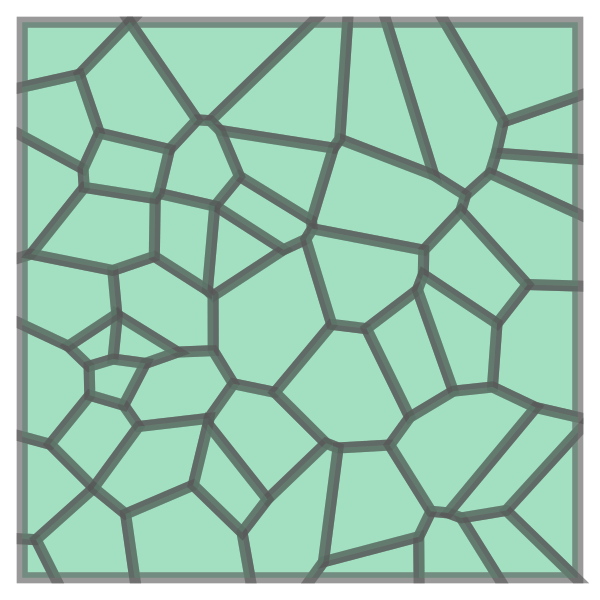

In [155]:
# scipy doesn't have a nice way to get these boundaries in a way that makes sense
SVG(result._repr_svg_().replace('width="108.0" height="108.0"', 'width="600.0" height="600.0"'))

CPU times: user 6.31 ms, sys: 10.7 ms, total: 17 ms
Wall time: 119 ms


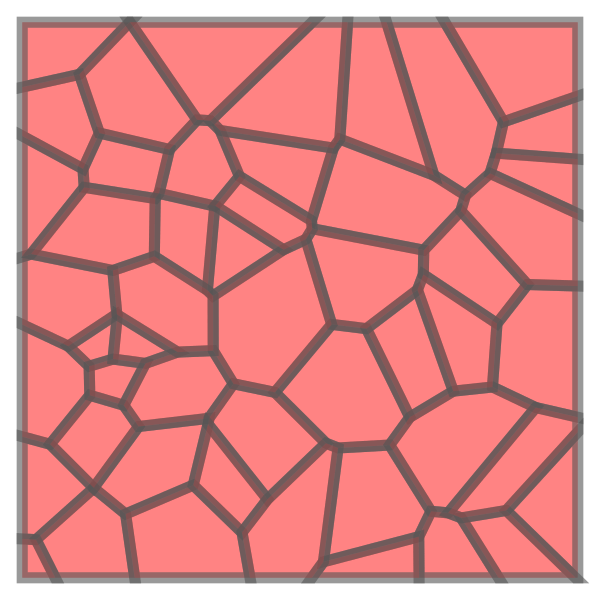

In [166]:
%%time
vville_voronoi =  voronoi(points_list, BoundingBox(0, 0, 100, 100))
vville_voronoi_polygons = geo.MultiPolygon([geo.Polygon(cell.vertices) for cell in vville_voronoi])
SVG(vville_voronoi_polygons._repr_svg_().replace('width="108.0" height="108.0"', 'width="600.0" height="600.0"'))

In [175]:
timing_benchmarks = []
for size in [100, 500, 1_000, 10_000, 100_000, 500_000, 1_000_000]:
    points = np.random.random(size=(size, 2)) * 100
    points_list = list(map(tuple, points.tolist()))
    time_scipy = %timeit Voronoi(points)
    time_vville = %timeit voronoi(points_list, BoundingBox(0, 0, 100, 100))
    time_vville_nn = %timeit voronoi(points_list, BoundingBox(0, 0, 100, 100), return_neighbors=False)
    data = {"size" : size, "time_scipy": time_scipy, "time_vville": time_vville, "time_vville_nn": time_vville_nn}


235 µs ± 5.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
59.4 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
44.6 µs ± 539 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [161]:
from itertools import chain

In [171]:
scipy_vertices = set(i for i in chain.from_iterable(chain.from_iterable([v.vertices[line].tolist() for line in v.ridge_vertices if -1 not in line])) if i <= 100 and i >= 0)
vville_vertices = set(chain.from_iterable(v.vertices for v in vville_voronoi))

In [172]:
len(scipy_vertices), len(vville_vertices)

(167, 102)